In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import copy
from scipy import sparse

In [2]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
from matplotlib.colors import Normalize
from matplotlib import cm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
norm = matplotlib.colors.Normalize(vmin=0, vmax=20)

import matplotlib.font_manager as font_manager
font_dirs = ['/project/elkabetz_lab_data/tools/PythonFonts/', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
matplotlib.rcParams['font.family'] = 'arial'
import pickle as pkl

In [3]:
from lik_models import *
from helper_funcs import *
from plotting_funcs import *
from mcmc_data import *

In [4]:
mcmc = mcmc_data(count_matrix_fn='/project/single_cell/Transcriptional_Cascades/data/e13_5_mouse_forebrain_neuron_diff.2.raw_count_matrix.tsv',
                          pkl_dir='/project/single_cell/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/outputs_full/e13_5_forebrain_dorsal_2/',
                          tfs_fn='/project/single_cell/Transcriptional_Cascades/data/mouse_transcription_factors_zhou_et_al.txt',
                          name='e13.5 Mouse Cortical Neuron')

Loading Count Matrix...
Normalizing Count Matrix...


In [5]:
#load in all pkls
mcmc.load_pkls(sub_tfs=False)

#get best fitting genes
mcmc.get_top_genes(n_top=50,sub_tf=False)

Loading pkls...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500


In [6]:
fit_types = {}
non_unif_fits = {}
for gene in mcmc.inflection_points:
    if mcmc.best_fits[gene] != 'uniform':
        non_unif_fits[gene] = mcmc.inflection_points[gene]
    else:
        fit_types[gene] = "uniform"
for type_ in ['sig down','sig up','transient up','transient down']:
    print(type_)
    for gene in [y[0] for y in sorted(non_unif_fits.items(),key = lambda x:get_mode(x[1],n_bins=50))]:
        if type_ is not None:
            keep = False
            if type_ == 'sig up':
                if mcmc.best_fits[gene] == 'sigmoidal':
                    if np.mean(mcmc.inflection_point_derivs[gene]) > 0:
                        fit_types[gene] = 'sig up'
                elif mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) > 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) > 0):
                        fit_types[gene] = 'sig up'
            elif type_ == 'sig down':
                if mcmc.best_fits[gene] == 'sigmoidal':
                    if np.mean(mcmc.inflection_point_derivs[gene]) < 0:
                        fit_types[gene] = 'sig down'
                elif mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) < 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) < 0):
                        fit_types[gene] = 'sig down'
            elif type_ == 'transient up':
                if mcmc.best_fits[gene] == 'gauss':
                    fit_types[gene] = 'transient up'
                if mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) > 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) < 0):
                        fit_types[gene] = 'transient up'
            elif type_ == 'transient down':
                if mcmc.best_fits[gene] == 'double sigmoidal':
                    if (np.mean(mcmc.inflection_point_derivs[gene]) < 0) & (np.mean(mcmc.inflection_point_derivs_2[gene]) > 0):
                        fit_types[gene] = 'transient down'

sig down
sig up
transient up
transient down


In [7]:
fitted_genes = [x for x in mcmc.best_fits.keys()]

In [8]:
import anndata as ad

In [9]:
adata = pkl.load(open('/project/single_cell/Daniel/Transcriptional_Cascades/scripts/Transcriptional_Cascades/data/e13.5_forebrain_dorsal_traj_adata_g23.pkl','rb'))

In [10]:
print(len(fitted_genes),len(set(fitted_genes).intersection(set(adata.var.index))))

9530 9530


In [11]:
len(adata.var)

15681

In [12]:
adata = adata[:,fitted_genes]

In [14]:
sc.pp.scale(adata,max_value=10)

/project/elkabetz_lab/Daniel/willow/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
#cluster genes together
#TODO: subset to same genes we tested for DE
# double check normalization (scale???) -- I think we need scaling...
# Try moving average(?)
adata_t = adata.transpose()

In [16]:
np.mean(adata_t.X[0,:])

-7.3616966e-09

In [19]:
%matplotlib inline

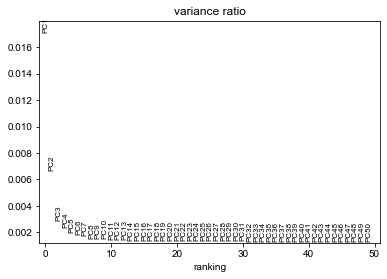

In [20]:
#run PCA
sc.tl.pca(adata_t, svd_solver='arpack', use_highly_variable=False)
sc.pl.pca_variance_ratio(adata_t, log=False, n_pcs=50)
plt.show()

([], [])

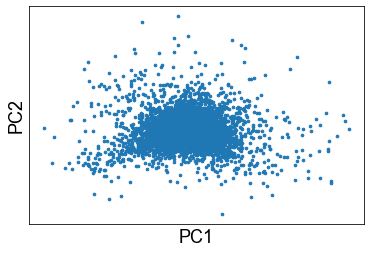

In [21]:
x = adata_t.obsm['X_pca'][:,0]
y = adata_t.obsm['X_pca'][:,1]
plt.scatter(x,y,s=7)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.xticks([])
plt.yticks([])

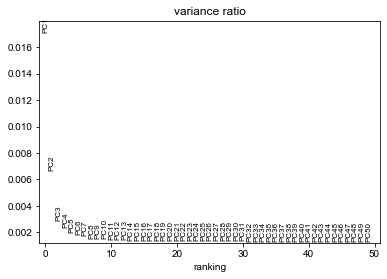

In [108]:
#run PCA
sc.tl.pca(adata_t, svd_solver='arpack', use_highly_variable=False)
sc.pl.pca_variance_ratio(adata_t, log=False, n_pcs=50)
plt.show()

In [185]:
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_dict = {'sig up':clrs[0],'sig down':clrs[1],'transient up':'limegreen','transient down':'gold','uniform':'whitesmoke'}

In [167]:
import random

/scratch/local/ipykernel_22532/1581046929.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  colors = np.array([color_dict[type_] for type_ in adata_t.obs['best_fit']])


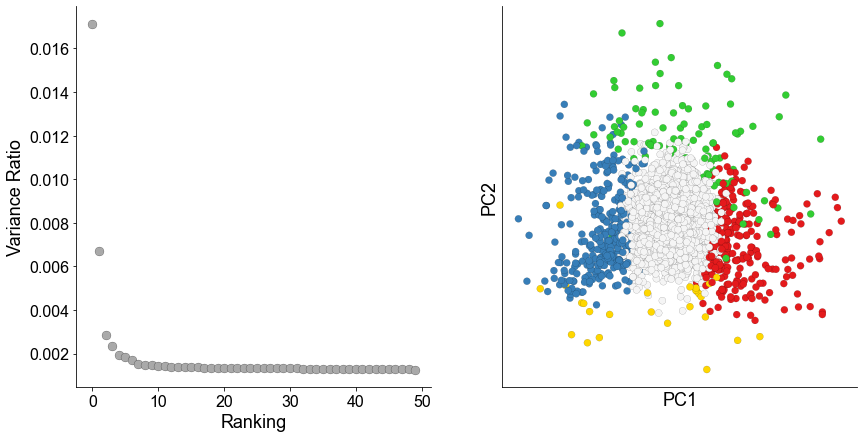

In [189]:
fig = plt.figure(figsize=(14,7))

ax = plt.subplot(121)
plt.scatter(range(len(adata_t.uns['pca']['variance_ratio'])),
            adata_t.uns['pca']['variance_ratio'],
            s=80,
            color='darkgrey',
            edgecolors='k',
            linewidths=0.2,
            label=type_)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Ranking',fontsize=18)
plt.ylabel('Variance Ratio',fontsize=18)
ax.spines[['right', 'top']].set_visible(False)

ax = plt.subplot(122)
x = adata_t.obsm['X_pca'][:,0]
y = adata_t.obsm['X_pca'][:,1]
colors = np.array([color_dict[type_] for type_ in adata_t.obs['best_fit']])
idx = list(range(len(x)))
random.seed(11)
random.shuffle(idx)

plt.scatter(x[idx],
                y[idx],
                s=50,
                c=colors[idx],
                edgecolors='k',
                linewidths=0.1,)

ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.xticks([])
plt.yticks([])
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=14)

plt.savefig('figures/pca_genes_by_fits.pdf',bbox_inches='tight')

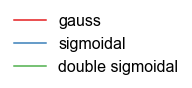

In [183]:
clrs = sns.color_palette('Set1', n_colors=10)  # a list of RGB tuples
color_dict = {'gauss':clrs[0],'sigmoidal':clrs[1],'double sigmoidal':clrs[2],'uniform':clrs[3]}
plt.figure(figsize=(0,0))
for type_ in ['gauss','sigmoidal','double sigmoidal']:
    plt.plot([0,0],[0,0],color=color_dict[type_],label=type_)
plt.axis('off')
plt.legend(frameon=False,fontsize=16)
plt.savefig('figures/fit_legend.pdf',bbox_inches='tight')

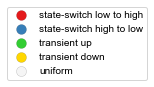

In [190]:
plt.figure(figsize=(0,0))

legend_map = {'sig down':'state-switch high to low',
              'sig up':'state-switch low to high',
              'transient up':'transient up',
              'transient down':'transient down',
              'uniform':'uniform'}

for type_ in ['sig up','sig down','transient up','transient down','uniform']:
    plt.scatter([],[],s=100,color=color_dict[type_],edgecolors='k',linewidths=0.1,label=legend_map[type_])

plt.axis('off')
plt.legend()

plt.savefig('figures/pca_genes_by_fits_legend.pdf',bbox_inches='tight')

In [204]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

1


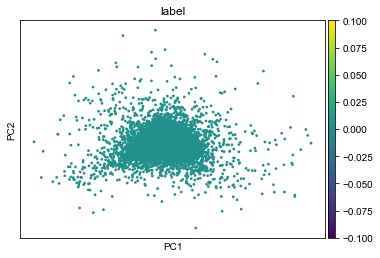

0    9530
Name: label, dtype: int64
2


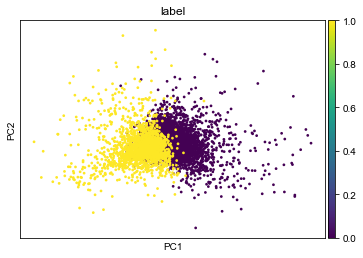

0    7584
1    1946
Name: label, dtype: int64
3


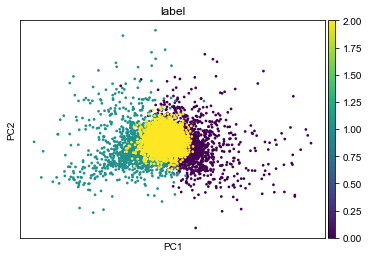

2    5698
1    1946
0    1886
Name: label, dtype: int64
4


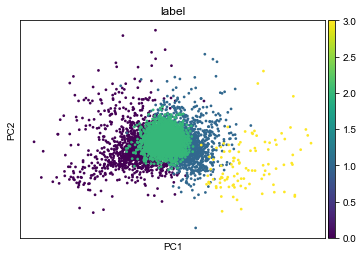

2    5698
0    1946
1    1783
3     103
Name: label, dtype: int64
5


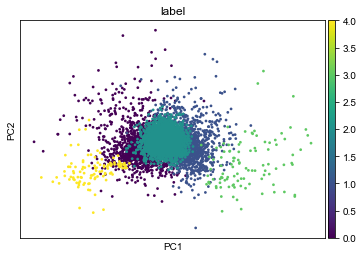

2    5698
0    1837
1    1783
4     109
3     103
Name: label, dtype: int64
6


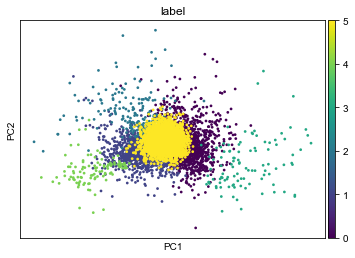

5    5698
0    1783
1    1623
2     214
4     109
3     103
Name: label, dtype: int64
7


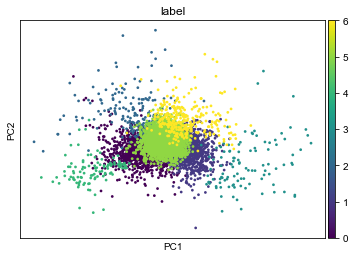

5    5698
0    1623
1    1474
6     309
2     214
4     109
3     103
Name: label, dtype: int64
8


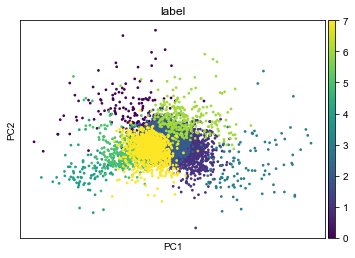

2    5698
1    1474
7    1140
5     483
6     309
0     214
4     109
3     103
Name: label, dtype: int64
9


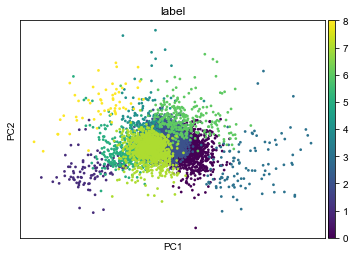

2    5698
0    1474
7    1140
5     483
6     309
4     155
1     109
3     103
8      59
Name: label, dtype: int64
10


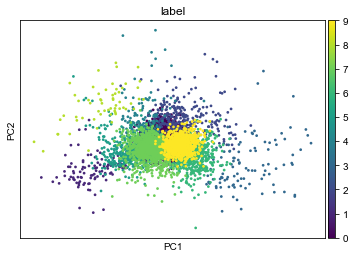

0    5698
7    1140
9     917
6     557
5     483
2     309
4     155
1     109
3     103
8      59
Name: label, dtype: int64


In [208]:
for i in range(1,11):
    adata_t.obs['label'] = labels[i-1]
    print(i)
    sc.pl.pca(adata_t,color=["label"],size=30,palette="nipy_spectral")#,annotate_var_explained=True)
    print(adata_t.obs['label'].value_counts())

In [205]:
data = adata_t.obsm['X_pca']
inertias = []
labels = []

for i in range(1,11):
    print(i)
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    labels.append(hierarchical_cluster.fit_predict(data))

1
2
3
4
5
6
7
8
9
10


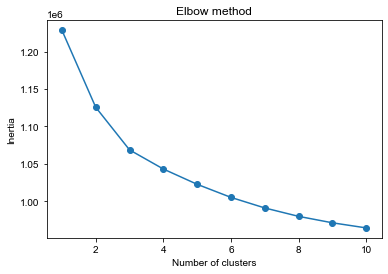

In [201]:
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

data = list(zip(x, y))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [27]:
adata_t.obs["best_fit"] = [fit_types[gene] for gene in adata_t.obs.index]

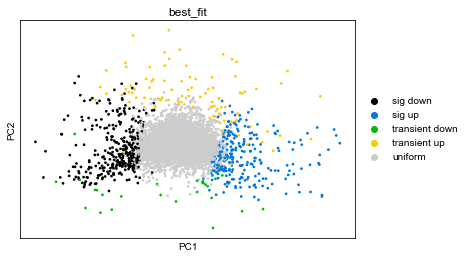

In [55]:
sc.pl.pca(adata_t,color=["best_fit"],size=30,palette="nipy_spectral")#,annotate_var_explained=True)